In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import itertools

In [ ]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()

subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
subject_data['timestamp_rounded'] = subject_data['timestamp'].round(3)

grouped = subject_data.groupby('timestamp_rounded')
real_data = []

for ts, group in grouped:
    entry = {'timestamp': ts}
    left = group[group['side'] == 'left']
    right = group[group['side'] == 'right']
    
    if not left.empty:
        left_xy = left[['X', 'Y']].iloc[0].to_numpy()
        entry['left'] = left_xy
    if not right.empty:
        right_xy = right[['X', 'Y']].iloc[0].to_numpy()
        entry['right'] = right_xy
    
    if 'left' in entry and 'right' in entry:
        entry['observed'] = 'both'
        entry['obs'] = np.concatenate([entry['left'], entry['right']])
    elif 'left' in entry:
        entry['observed'] = 'left'
        entry['obs'] = entry['left']
    elif 'right' in entry:
        entry['observed'] = 'right'
        entry['obs'] = entry['right']
    else:
        entry['observed'] = 'none'
        entry['obs'] = np.array([])

    real_data.append(entry)

DT_VIRT = 0.5
SIGMA_MIN = 0.000001
SIGMA_MAX = 10
sigma_v_values = [0.01, 0.05, 0.1, 0.5]
sigma_omega_values = [0.001, 0.01, 0.05, 0.1]
sigma_obs_values = [0.5, 1]
param_combinations = list(itertools.product(sigma_v_values, sigma_omega_values, sigma_obs_values))
results = []

In [ ]:
def track_parameters(params):
    global param_history, iteration_count
    
    sigma_v, sigma_omega, sigma_obs, d = params
    
    param_history['iteration'].append(iteration_count)
    param_history['sigma_v'].append(sigma_v)
    param_history['sigma_omega'].append(sigma_omega)
    param_history['sigma_obs'].append(sigma_obs)
    param_history['d'].append(d)
    
    iteration_count += 1
    
def state_transition(s_t, delta_t):
    x, y, theta, vx, vy, omega = s_t
    return np.array([
        x + vx * delta_t,
        y + vy * delta_t,
        theta + omega * delta_t,
        vx,
        vy,
        omega
    ])

def jacobian_F(delta_t):
    return np.array([
        [1, 0, 0, delta_t, 0, 0],
        [0, 1, 0, 0, delta_t, 0],
        [0, 0, 1, 0, 0, delta_t],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

def h(s_t, observed_sensors, d):
    x, y, theta = s_t[0], s_t[1], s_t[2]
    if observed_sensors == 'both':
        # Lx, Ly, Rx, Ry
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta),
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    elif observed_sensors == 'left':
        return np.array([x - d * np.sin(theta), y + d * np.cos(theta)])
    elif observed_sensors == 'right':
        return np.array([x + d * np.sin(theta), y - d * np.cos(theta)])
    else:  # 'none'
        return np.array([])

def jacobian_h(s_t, observed_sensors, d):
    theta = s_t[2]
    if observed_sensors == 'both':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0, 0],
            [1, 0, d * np.cos(theta), 0, 0, 0],
            [0, 1, d * np.sin(theta), 0, 0, 0]
        ])
    elif observed_sensors == 'left':
        return np.array([
            [1, 0, -d * np.cos(theta), 0, 0, 0],
            [0, 1, -d * np.sin(theta), 0, 0, 0]
        ])
    elif observed_sensors == 'right':
        return np.array([
            [1, 0, d * np.cos(theta), 0, 0, 0],
            [0, 1, d * np.sin(theta), 0, 0, 0]
        ])
    else:  # 'none'
        return np.zeros((0, 6))

In [ ]:
def ekf_forward(data, timestamps, virtual_timestamps, params):
    sigma_v, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_hat = [np.zeros(6)] * T  # Predicted states
    P = [np.zeros((6, 6))] * T  # Predicted covariances
    s_filt = [np.zeros(6)] * T  # Filtered states
    P_filt = [np.zeros((6, 6))] * T  # Filtered covariances
    neg_log_likelihood = 0.0  # Initialize negative log-likelihood for minimization

    # Initialize state and covariance
    s_hat[0] = np.zeros(6)
    # Try to initialize with first observation if available
    for entry in data[:10]:
        if entry['observed'] != 'none':
            if entry['observed'] == 'left':
                s_hat[0][:2] = entry['left']
                break
            elif entry['observed'] == 'right':
                s_hat[0][:2] = entry['right']
                break
            elif entry['observed'] == 'both':
                s_hat[0][:2] = (entry['left'] + entry['right']) / 2
                break
                
    P[0] = np.diag([10, 10, 10, 5, 5, 2])  # Initial uncertainty
    s_filt[0] = s_hat[0]  # Initialize filtered state with predicted state
    P_filt[0] = P[0]      # Initialize filtered covariance with predicted covariance

    for k in range(T - 1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k

        # Prediction step
        s_hat[k + 1] = state_transition(s_filt[k], delta_t)
        F_k = jacobian_F(delta_t)
        # Modified process noise: same sigma_v for both vx and vy
        Q_k = np.diag([0, 0, 0, sigma_v**2 * delta_t**2, sigma_v**2 * delta_t**2, sigma_omega**2 * delta_t**2])
        P[k + 1] = F_k @ P_filt[k] @ F_k.T + Q_k

        # Update step (only for actual timestamps with observations)
        if t_k1 in timestamps:
            idx = timestamps.index(t_k1)
            observed_sensors = data[idx]['observed']
            if observed_sensors != 'none':
                H_k1 = jacobian_h(s_hat[k + 1], observed_sensors, d)
                z_pred = h(s_hat[k + 1], observed_sensors, d)
                z_k1 = data[idx]['obs']
                m_t = len(z_k1)
                R = sigma_obs**2 * np.eye(m_t)
                S_k1 = H_k1 @ P[k + 1] @ H_k1.T + R
                
                # Ensure S_k1 is positive definite for numerical stability
                S_k1 = (S_k1 + S_k1.T) / 2  # Make symmetric
                
                try:
                    # Calculate innovation and its contribution to negative log likelihood
                    innovation = z_k1 - z_pred
                    sign, logdet = np.linalg.slogdet(S_k1)
                    if sign > 0:  # Check if determinant is positive
                        # Use log determinant formula for numerical stability
                        neg_log_likelihood += 0.5 * (m_t * np.log(2 * np.pi) + logdet + 
                                              innovation @ np.linalg.inv(S_k1) @ innovation)
                    else:
                        print(sign, logdet)
                        print('S_k1', S_k1)
                        raise np.linalg.LinAlgError("S_k1 is not positive definite")
                    # Kalman gain and state update
                    K_k1 = P[k + 1] @ H_k1.T @ np.linalg.inv(S_k1)
                    s_filt[k + 1] = s_hat[k + 1] + K_k1 @ innovation
                    P_filt[k + 1] = (np.eye(6) - K_k1 @ H_k1) @ P[k + 1]
                except np.linalg.LinAlgError:
                    print('parameters:', params)
                    print('S_k1', S_k1)
                    print('Innovation:', innovation)
                    print('P[k + 1]:', P[k + 1])
                    print('H_k1:', H_k1)
                    print('z_pred:', z_pred)
                    print('z_k1:', z_k1)
                    print('s_hat[k + 1]:', s_hat[k + 1])
                    raise
            else:
                s_filt[k + 1] = s_hat[k + 1]
                P_filt[k + 1] = P[k + 1]
        else:
            s_filt[k + 1] = s_hat[k + 1]
            P_filt[k + 1] = P[k + 1]
            
    return s_filt, P_filt, s_hat, P, neg_log_likelihood

In [ ]:
def smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps):
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    s_smooth = [np.zeros(6)] * T
    P_smooth = [np.zeros((6, 6))] * T
    s_smooth[-1] = s_filt[-1]
    P_smooth[-1] = P_filt[-1]

    for k in range(T - 2, -1, -1):
        t_k = master_timestamps[k]
        t_k1 = master_timestamps[k + 1]
        delta_t = t_k1 - t_k
        F_k = jacobian_F(delta_t)
        
        try:
            C_k = P_filt[k] @ F_k.T @ np.linalg.inv(P[k + 1])
            s_smooth[k] = s_filt[k] + C_k @ (s_smooth[k + 1] - s_hat[k + 1])
            P_smooth[k] = P_filt[k] + C_k @ (P_smooth[k + 1] - P[k + 1]) @ C_k.T
        except np.linalg.LinAlgError:
            s_smooth[k] = s_filt[k]
            P_smooth[k] = P_filt[k]

    return s_smooth, P_smooth

def add_noise_to_parameters(params, noise_std=0.075):
    sigma_v, sigma_omega, sigma_obs, d = params
    
    sigma_v_noise = sigma_v * (1 + np.random.normal(0, noise_std))
    sigma_omega_noise = sigma_omega * (1 + np.random.normal(0, noise_std))
    sigma_obs_noise = sigma_obs * (1 + np.random.normal(0, noise_std))
    d_noise = d * (1 + np.random.normal(0, noise_std))
    
    sigma_v_noise = np.clip(sigma_v_noise, SIGMA_MIN, SIGMA_MAX)
    sigma_omega_noise = np.clip(sigma_omega_noise, SIGMA_MIN, SIGMA_MAX)
    sigma_obs_noise = np.clip(sigma_obs_noise, 0.01, SIGMA_MAX)
    d_noise = np.clip(d_noise, 0.01, 1.0)
    
    return [sigma_v_noise, sigma_omega_noise, sigma_obs_noise, d_noise]

def optimize_parameters(data, timestamps, virtual_timestamps, initial_params):
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),  # sigma_v
        (SIGMA_MIN, SIGMA_MAX),  # sigma_omega
        (0.01, SIGMA_MAX),       # sigma_obs
        (0.01, 1.0)              # d (distance between sensors)
    ]
    
    def objective(params):
        try:
            _, _, _, _, neg_log_likelihood = ekf_forward(data, timestamps, virtual_timestamps, params)
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            return np.inf
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': False, 'maxiter': 20}
    )
    
    return result.x

np.random.seed(42)


Test 1
Initial: sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.04537543 0.00620901 0.50364112 0.22336579]
    Iteration 1 - Params with noise: [0.04706582300500225, 0.006144628338443649, 0.5281063110337304, 0.2488802463693983]
    Iteration 1 - Negative log likelihood: 4509.311727
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05869687 0.00822367 0.40908451 0.40810005]
    Iteration 2 - Params with noise: [0.057666063191284075, 0.008079261047232708, 0.45753687796454223, 0.43158930838295567]
    Iteration 2 - Negative log likelihood: 4194.873125
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05594242 0.00835944 0.41234558 0.40937466]
    Iteration 3 - Params with noise: [0.05397265961706999, 0.00869959927077482, 0.3980139621991623, 0.3950753120622985]
    Iteration 3 - Negative log likelihood: 4193.843715
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05594004 0.00835909 0.4123

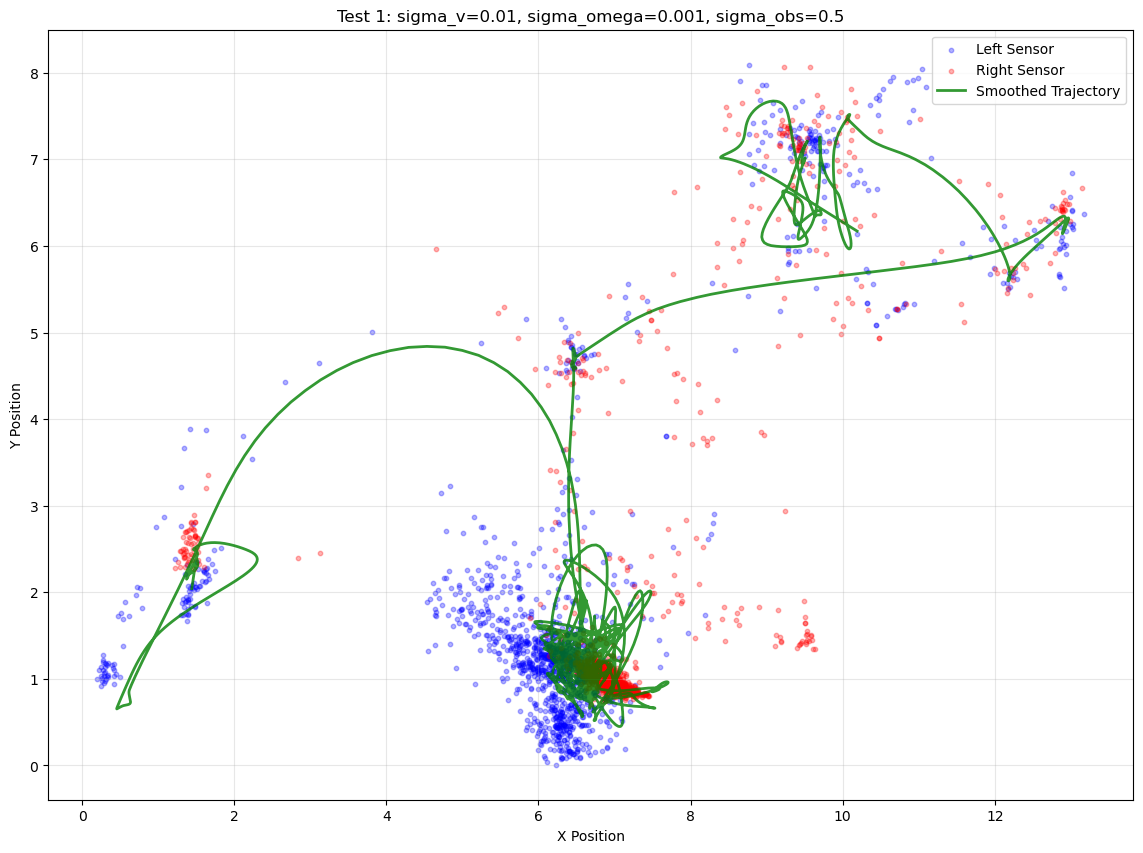


Test 2
Initial: sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.00782173 0.00114014 0.72680433 0.44238505]
    Iteration 1 - Params with noise: [0.008254934804158787, 0.0011547946723195952, 0.7205003030641185, 0.43239476426775664]
    Iteration 1 - Negative log likelihood: 6313.033243
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.02072916 0.00109686 0.73210171 0.433142  ]
    Iteration 2 - Params with noise: [0.01843052261575579, 0.0010376411478448628, 0.7068091302289412, 0.4674833062801641]
    Iteration 2 - Negative log likelihood: 6154.901928
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.01843052 0.00103764 0.70680913 0.46748331]
    Iteration 3 - Params with noise: [0.018905502465036705, 0.000900435922056825, 0.723989043368622, 0.4539818409572447]
    Iteration 3 - Negative log likelihood: 6289.704416
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.02992966 0.00078023 0.6002

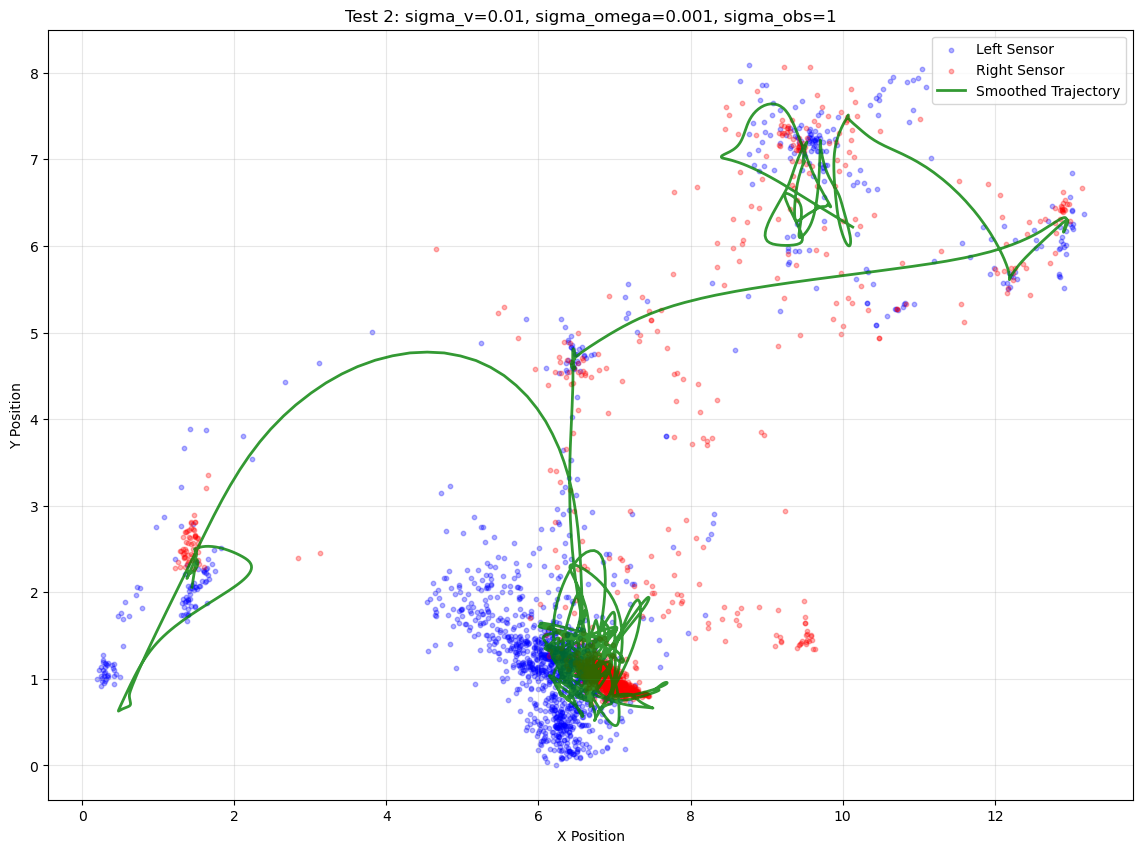


Test 3
Initial: sigma_v: 0.01, sigma_omega: 0.01, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.02708304 0.01150284 0.50902442 0.24422506]
    Iteration 1 - Params with noise: [0.026636833314225974, 0.011810926364244828, 0.5654457267901991, 0.23473196719968753]
    Iteration 1 - Negative log likelihood: 4547.332521
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.02663683 0.01181093 0.56544573 0.23473197]
    Iteration 2 - Params with noise: [0.025021655114034688, 0.011366460202155967, 0.6042664929713993, 0.24051959680139987]
    Iteration 2 - Negative log likelihood: 4719.781064
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.08642306 0.0522197  0.38285055 0.41098532]
    Iteration 3 - Params with noise: [0.08298929573249254, 0.054229902209382175, 0.3856380131671443, 0.4408427355842208]
    Iteration 3 - Negative log likelihood: 4124.928236
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.08347611 0.05379032 0.382

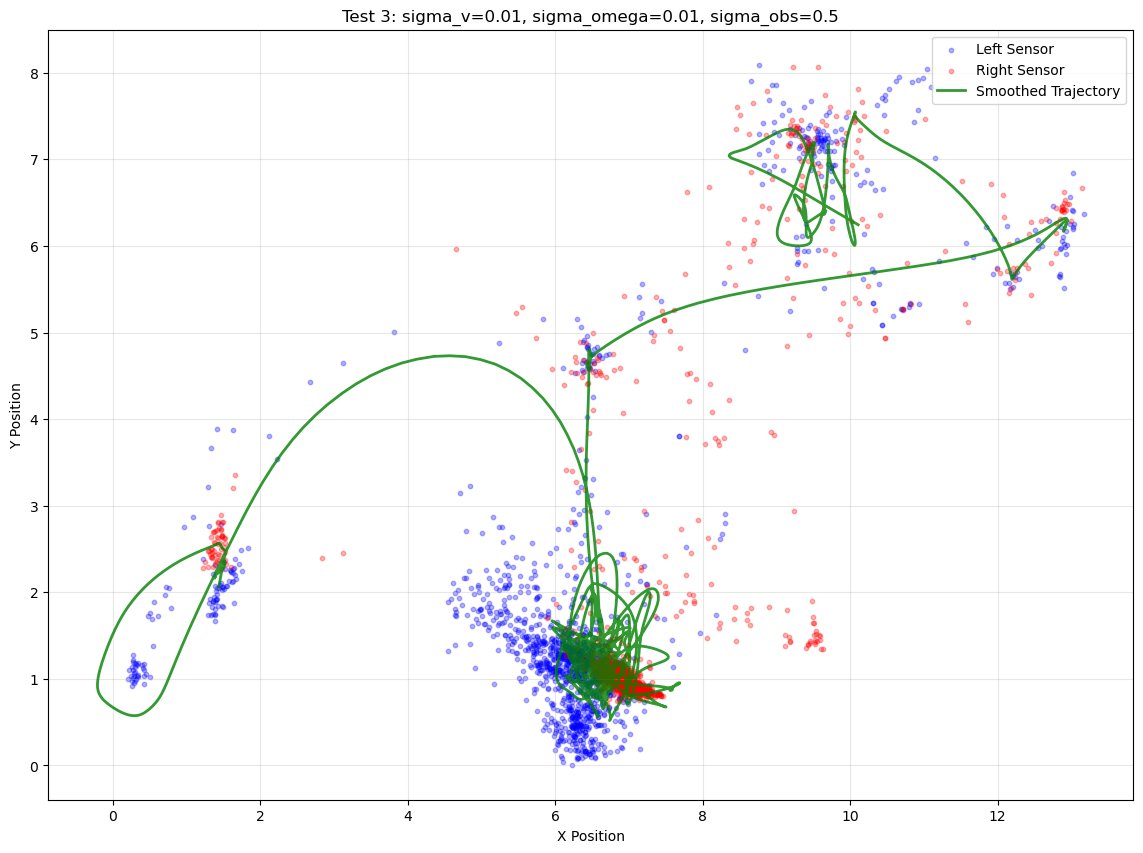


Test 4
Initial: sigma_v: 0.01, sigma_omega: 0.01, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.0511042  0.01674722 0.39868732 0.28413799]
    Iteration 1 - Params with noise: [0.05413607386482912, 0.015604988515343927, 0.440633042319188, 0.25426405143689373]
    Iteration 1 - Negative log likelihood: 4279.550783
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.0390795  0.03638184 0.42268948 0.31827887]
    Iteration 2 - Params with noise: [0.04079955963457003, 0.042358799666780605, 0.3912877870541785, 0.3047608229261412]
    Iteration 2 - Negative log likelihood: 4222.618269
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.04650895 0.04335227 0.42177406 0.32167737]
    Iteration 3 - Params with noise: [0.04685655394318965, 0.04171525816736956, 0.3727218348365766, 0.3233315044654587]
    Iteration 3 - Negative log likelihood: 4193.070969
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.0758478  0.04096417 0.38828715 0

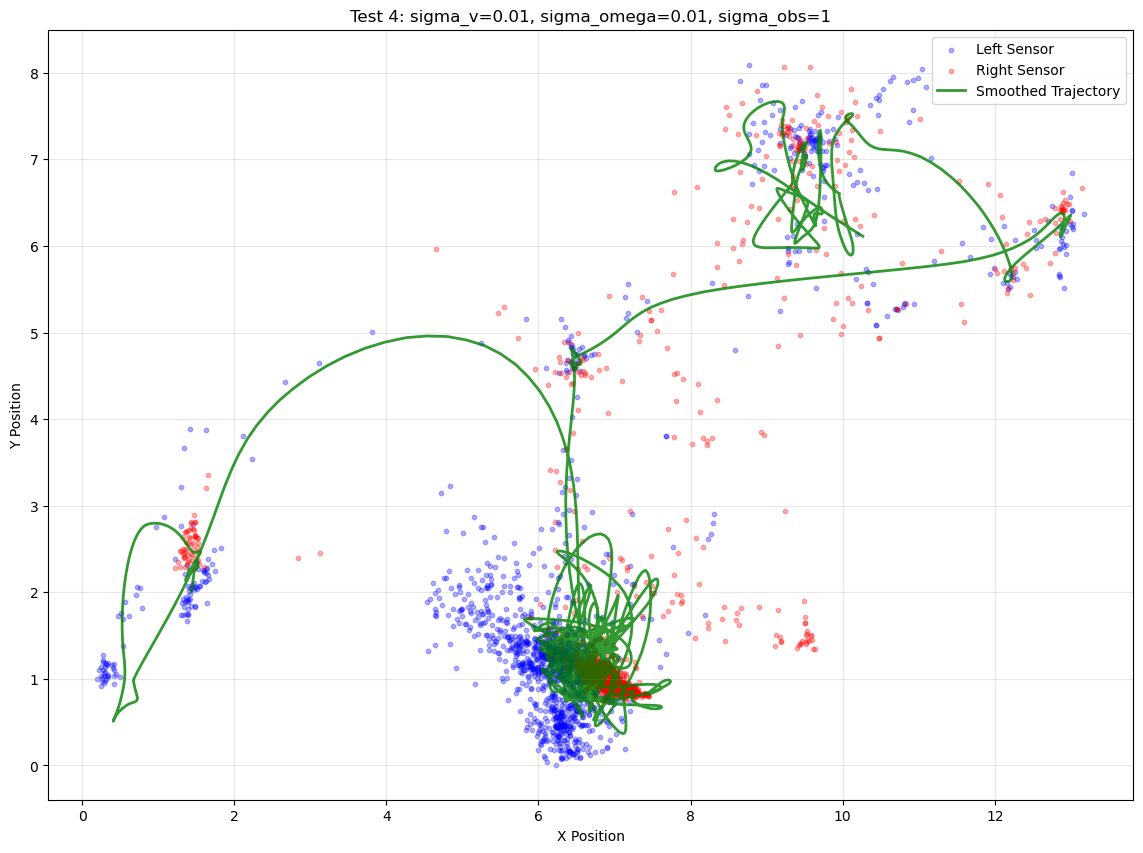


Test 5
Initial: sigma_v: 0.01, sigma_omega: 0.05, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.05933274 0.05831519 0.3916956  0.38631333]
    Iteration 1 - Params with noise: [0.05499545386367668, 0.06175761535481287, 0.4257318547265959, 0.3625352918239909]
    Iteration 1 - Negative log likelihood: 4140.250605
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.06253098 0.05434502 0.39302603 0.39187618]
    Iteration 2 - Params with noise: [0.06704904722049429, 0.056027465999001325, 0.41725785468329374, 0.44762427570469476]
    Iteration 2 - Negative log likelihood: 4117.607036
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05712251 0.05304806 0.39663189 0.41557397]
    Iteration 3 - Params with noise: [0.056071218758977796, 0.05004923807540382, 0.3701711543746602, 0.3901467556251051]
    Iteration 3 - Negative log likelihood: 4134.245884
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.06253007 0.05434415 0.393021

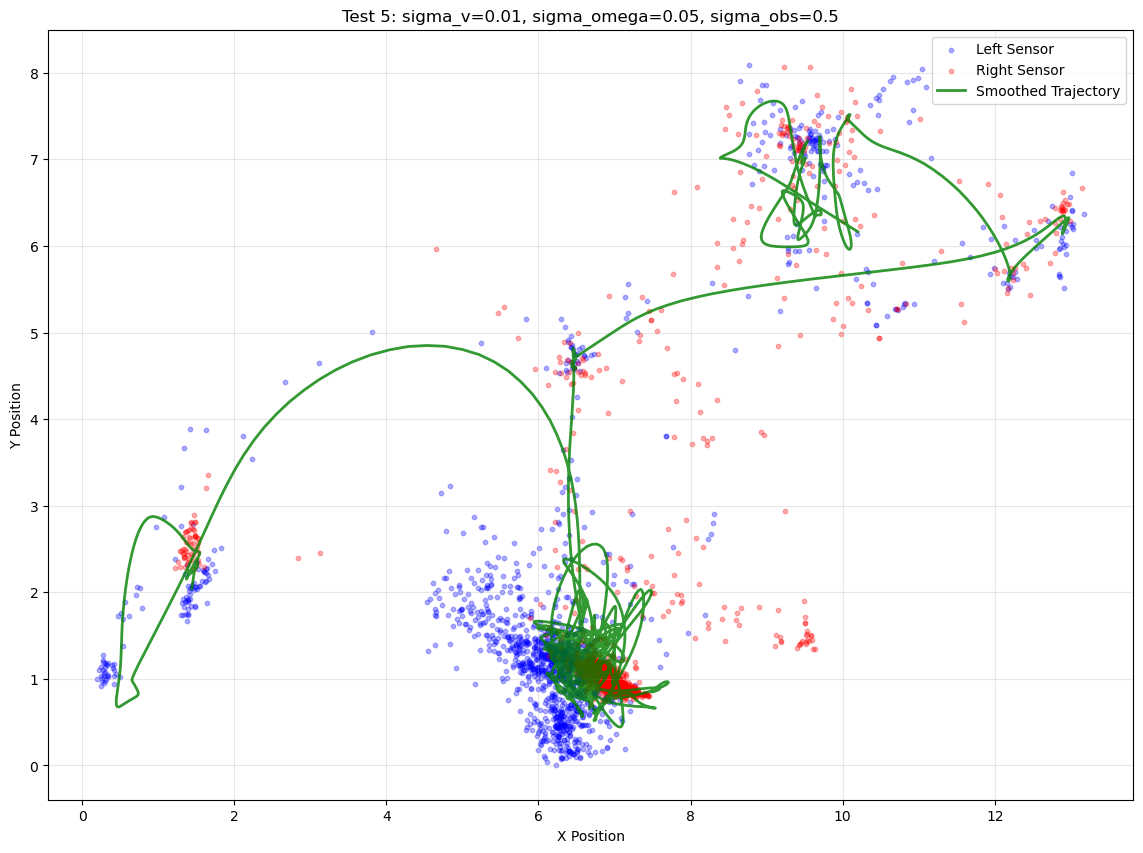


Test 6
Initial: sigma_v: 0.01, sigma_omega: 0.05, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.06544323 0.03128934 0.39179666 0.35589685]
    Iteration 1 - Params with noise: [0.06719933808527631, 0.03260533547868577, 0.42362185135701486, 0.3840252159211867]
    Iteration 1 - Negative log likelihood: 4174.648647
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.06437485 0.03340225 0.39535074 0.41964626]
    Iteration 2 - Params with noise: [0.057723303949379044, 0.031052836206295797, 0.4106222045223163, 0.43581688824355]
    Iteration 2 - Negative log likelihood: 4126.675364
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.06437488 0.03340222 0.39535075 0.41964649]
    Iteration 3 - Params with noise: [0.06686158807773732, 0.043053957694619165, 0.41227839444931, 0.45538670523261054]
    Iteration 3 - Negative log likelihood: 4126.675364
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.06353981 0.04143066 0.39360636 0.

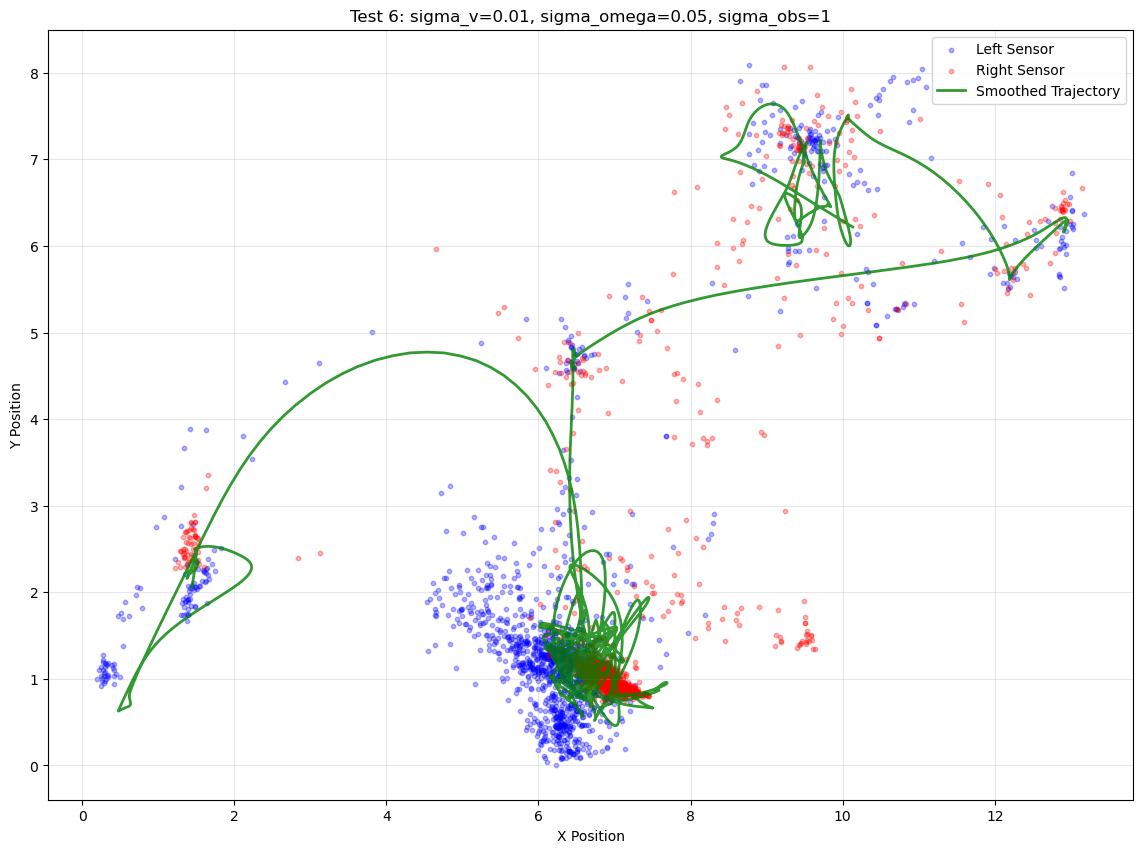


Test 7
Initial: sigma_v: 0.01, sigma_omega: 0.1, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.01 0.1  0.5  0.23]
    Iteration 1 - Params with noise: [0.009405609446175476, 0.09913947668899827, 0.5189370229617671, 0.2449342770994346]
    Iteration 1 - Negative log likelihood: 4893.840313
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.05145092 0.05973877 0.39905602 0.35458824]
    Iteration 2 - Params with noise: [0.046819194401415215, 0.05824007004060949, 0.38484128345611357, 0.3372135222298898]
    Iteration 2 - Negative log likelihood: 4154.326898
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.05156612 0.06102387 0.40367198 0.35311952]
    Iteration 3 - Params with noise: [0.05839394638166809, 0.06287738797112741, 0.36549821709971037, 0.37742814618898324]
    Iteration 3 - Negative log likelihood: 4161.152344
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.0662978  0.0535357  0.39322653 0.38904137]
    Itera

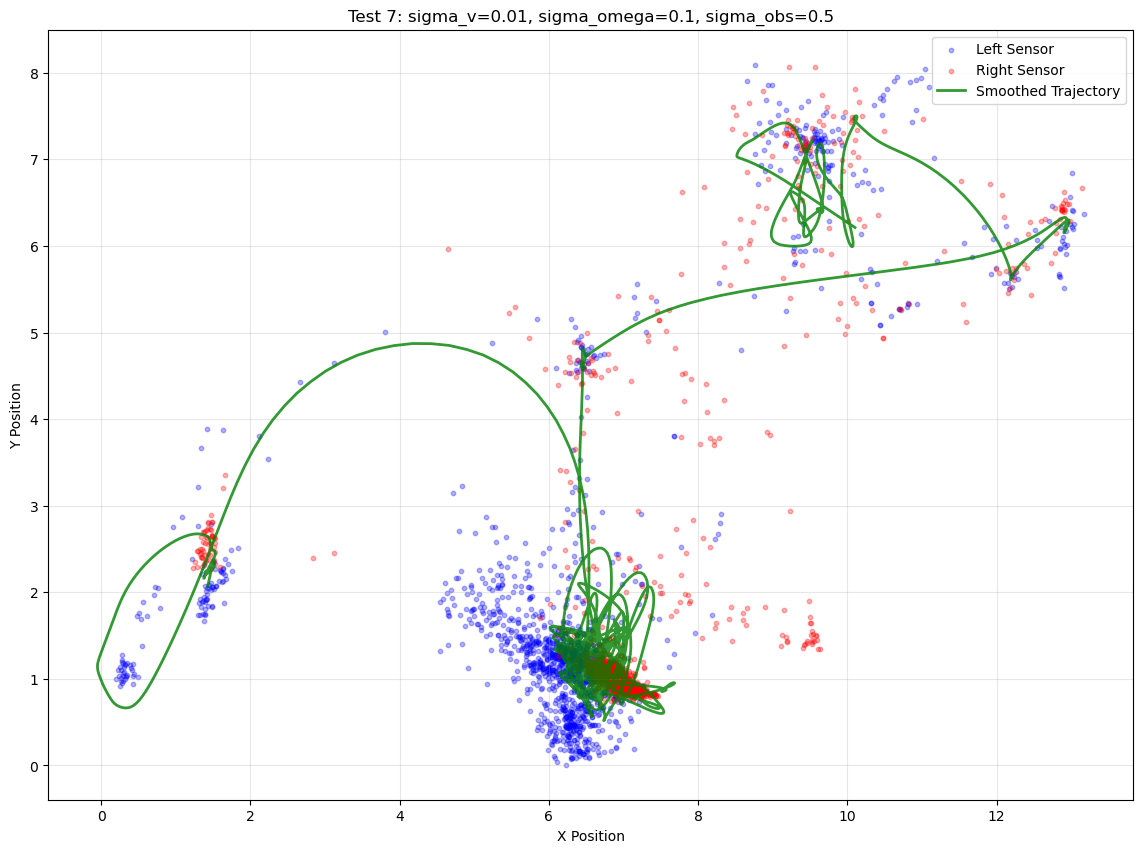


Test 8
Initial: sigma_v: 0.01, sigma_omega: 0.1, sigma_obs: 1
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.1015077  0.07929674 0.4616569  0.32297101]
    Iteration 1 - Params with noise: [0.10237191563187796, 0.08323459986183125, 0.5165715746821158, 0.29298761730786904]
    Iteration 1 - Negative log likelihood: 4438.966915
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.08648385 0.0408919  0.38416835 0.3925647 ]
    Iteration 2 - Params with noise: [0.10031931682030933, 0.03490505418333478, 0.3797950251670146, 0.4098861436135439]
    Iteration 2 - Negative log likelihood: 4120.827253
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.10163168 0.0355314  0.38066879 0.41304818]
    Iteration 3 - Params with noise: [0.10377350766099881, 0.03387199634921603, 0.37472686435941005, 0.39777569641935445]
    Iteration 3 - Negative log likelihood: 4216.032731
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.08509553 0.0419365  0.38175544 0

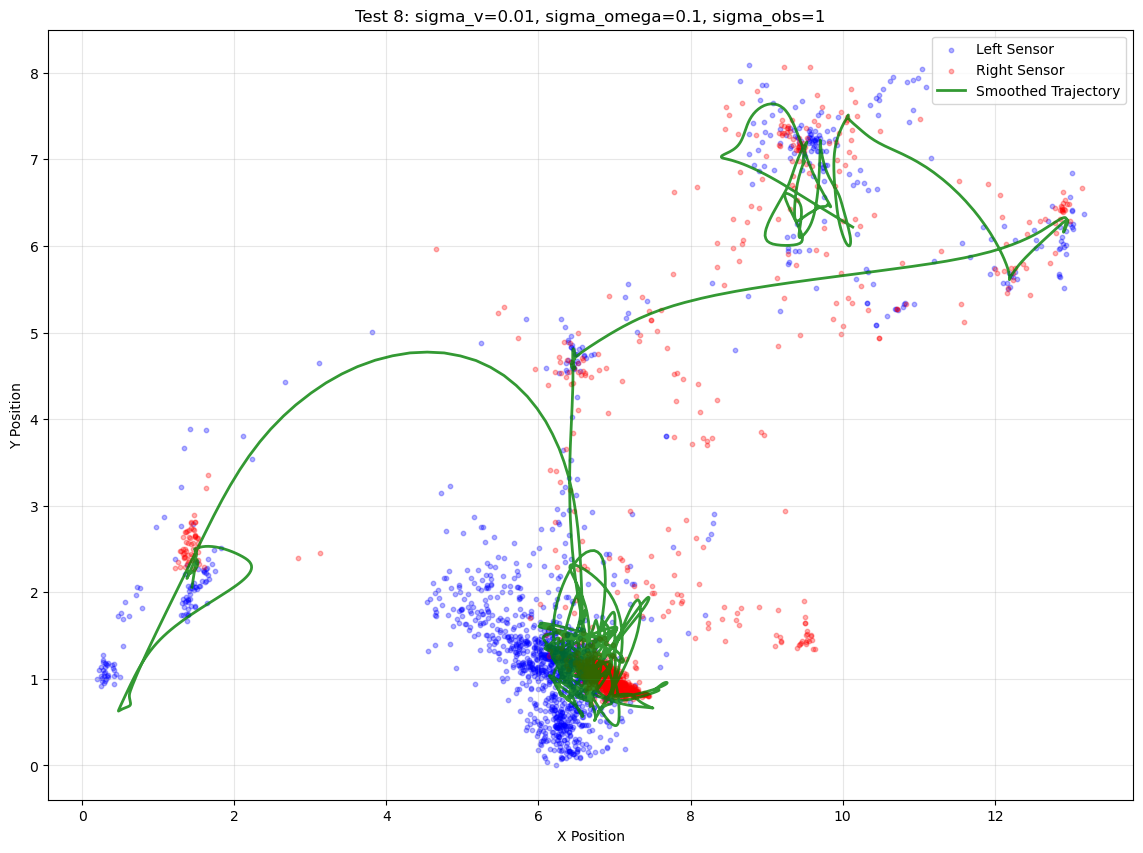


Test 9
Initial: sigma_v: 0.05, sigma_omega: 0.001, sigma_obs: 0.5
  Outer iteration 1/10
    Iteration 1 - Optimized params: [0.04798922 0.00112694 0.49778231 0.23624014]
    Iteration 1 - Params with noise: [0.0483383306257048, 0.0011772396917179267, 0.4672351267919491, 0.2733130791683584]
    Iteration 1 - Negative log likelihood: 4532.489782
  Outer iteration 2/10
    Iteration 2 - Optimized params: [0.04840181 0.00529226 0.44967569 0.28147554]
    Iteration 2 - Params with noise: [0.04474983429642892, 0.004810324617343386, 0.48873376130859425, 0.29818806458192226]
    Iteration 2 - Negative log likelihood: 4400.784235
  Outer iteration 3/10
    Iteration 3 - Optimized params: [0.03503414 0.00733561 0.48071402 0.30177152]
    Iteration 3 - Params with noise: [0.03667404995109976, 0.007681304283591011, 0.4802724781335408, 0.28146408007165935]
    Iteration 3 - Negative log likelihood: 4399.006727
  Outer iteration 4/10
    Iteration 4 - Optimized params: [0.05898687 0.00875894 0.424

In [ ]:
for i, (sigma_v, sigma_omega, sigma_obs) in enumerate(param_combinations):
    print(f"\nTest {i+1}")
    print(f"Initial: sigma_v: {sigma_v}, sigma_omega: {sigma_omega}, sigma_obs: {sigma_obs}")
    
    try:
        # Initial parameters: [sigma_v, sigma_omega, sigma_obs, d]
        initial_params = [sigma_v, sigma_omega, sigma_obs, 0.23]
        max_data_points = 3000
        data_subset = real_data[:max_data_points]
        timestamps = [entry['timestamp'] for entry in data_subset]
        virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
        
        current_params = initial_params.copy()
        
        for outer_iter in range(10):
            print(f"  Outer iteration {outer_iter + 1}/10")
            optimized_params = optimize_parameters(data_subset, timestamps, virtual_timestamps, current_params)
            current_params = add_noise_to_parameters(optimized_params, noise_std=0.075)
            _, _, _, _, likelihood = ekf_forward(data_subset, timestamps, virtual_timestamps, optimized_params)
            
            print(f"    Iteration {outer_iter + 1} - Optimized params: {optimized_params}")
            print(f"    Iteration {outer_iter + 1} - Params with noise: {current_params}")
            print(f"    Iteration {outer_iter + 1} - Negative log likelihood: {likelihood:.6f}")
        
        # Final optimization without noise
        final_params = optimize_parameters(data_subset, timestamps, virtual_timestamps, current_params)
        
        # Use the final optimized parameters for final evaluation
        s_filt, P_filt, s_hat, P, neg_log_likelihood = ekf_forward(data_subset, timestamps, virtual_timestamps, final_params)
        s_smooth, P_smooth = smoother(s_filt, P_filt, s_hat, P, timestamps, virtual_timestamps)
        
        result_dict = {
            'combination_id': i+1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'initial_d': 0.23,
            'final_sigma_v': final_params[0],
            'final_sigma_omega': final_params[1],
            'final_sigma_obs': final_params[2],
            'final_d': final_params[3],
            'negative_log_likelihood': neg_log_likelihood,
            'optimization_success': True
        }
        results.append(result_dict)
        print(f"Final optimized params: {final_params}")
        print(f"Final negative log-likelihood: {neg_log_likelihood}")
        
        master_timestamps = sorted(set(timestamps + virtual_timestamps))
        
        # Visualization
        plt.figure(figsize=(14, 10))
        plt.title(f'Test {i+1}: sigma_v={sigma_v}, sigma_omega={sigma_omega}, sigma_obs={sigma_obs}')
        left_x, left_y = [], []
        right_x, right_y = [], []
        
        for entry in data_subset:
            if 'left' in entry:
                left_x.append(entry['left'][0])
                left_y.append(entry['left'][1])
            if 'right' in entry:
                right_x.append(entry['right'][0])
                right_y.append(entry['right'][1])
        
        plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
        plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)
        plt.plot([s[0] for s in s_smooth], [s[1] for s in s_smooth], 'g-', alpha=0.8, linewidth=2, label='Smoothed Trajectory')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.show()
        
    except Exception as e:
        print(f"Error in combination {i+1}: {str(e)}")
        result_dict = {
            'combination_id': i + 1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'initial_d': 0.23,
            'final_sigma_v': np.nan,
            'final_sigma_omega': np.nan,
            'final_sigma_obs': np.nan,
            'final_d': np.nan,
            'negative_log_likelihood': np.inf,
            'optimization_success': False
        }
        results.append(result_dict)

# Save results
results_df = pd.DataFrame(results)
output_filename = f'ekf_parameter_optimization_results_101922_27_loop_with_noise.csv'
results_df.to_csv(output_filename, index=False)

print(f"\nOptimization complete. Results saved to {output_filename}")
print(f"Total successful optimizations: {sum(1 for r in results if r['optimization_success'])}")

# Find and display best result
successful_results = [r for r in results if r['optimization_success']]
if successful_results:
    best_result = min(successful_results, key=lambda x: x['negative_log_likelihood'])
    print(f"\nBest result:")
    print(f"Combination ID: {best_result['combination_id']}")
    print(f"Initial parameters: sigma_v={best_result['initial_sigma_v']}, sigma_omega={best_result['initial_sigma_omega']}, sigma_obs={best_result['initial_sigma_obs']}, d={best_result['initial_d']}")
    print(f"Final parameters: sigma_v={best_result['final_sigma_v']:.6f}, sigma_omega={best_result['final_sigma_omega']:.6f}, sigma_obs={best_result['final_sigma_obs']:.6f}, d={best_result['final_d']:.6f}")
    print(f"Negative log likelihood: {best_result['negative_log_likelihood']:.6f}")